In [1]:
%matplotlib inline

In [44]:
# yellowbrick.regressor.residuals
# Regressor visualizers that score residuals: prediction vs. actual data.
#
# Author:   Rebecca Bilbro <rbilbro@districtdatalabs.com>
# Author:   Benjamin Bengfort <bbengfort@districtdatalabs.com>
# Created:  Fri Jun 03 10:30:36 2016 -0700
#
# Copyright (C) 2016 2016 District Data Labs
# For license information, see LICENSE.txt
#
# ID: residuals.py [7d3f5e6] benjamin@bengfort.com $

"""
Regressor visualizers that score residuals: prediction vs. actual data.
"""

##########################################################################
## Imports
##########################################################################

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from yellowbrick.style.palettes import LINE_COLOR
from yellowbrick.regressor import RegressionScoreVisualizer
from yellowbrick.exceptions import YellowbrickTypeError
from yellowbrick.bestfit import draw_best_fit #, draw_identity_line


## Packages for export
__all__ = [
    "PredictionError", "prediction_error",
    "ResidualsPlot", "residuals_plot"
]

##########################################################################
## Prediction Error Plots
##########################################################################

class PredictionError(RegressionScoreVisualizer):
    """
    The prediction error visualizer plots the actual targets from the dataset
    against the predicted values generated by our model(s). This visualizer is
    used to dectect noise or heteroscedasticity along a range of the target
    domain.
    Parameters
    ----------
    model : a Scikit-Learn regressor
        Should be an instance of a regressor, otherwise a will raise a
        YellowbrickTypeError exception on instantiation.
    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).
    shared_limits : bool, default: True
        If shared_limits is True, the range of the X and Y axis limits will
        be identical, creating a square graphic with a true 45 degree line.
        In this form, it is easier to diagnose under- or over- prediction,
        though the figure will become more sparse. To localize points, set
        shared_limits to False, but note that this will distort the figure
        and should be accounted for during analysis.
    besfit : bool, default: True
        Draw a linear best fit line to estimate the correlation between the
        predicted and measured value of the target variable. The color of
        the bestfit line is determined by the ``line_color`` argument.
    identity: bool, default: True
        Draw the 45 degree identity line, y=x in order to better show the
        relationship or pattern of the residuals. E.g. to estimate if the
        model is over- or under- estimating the given values. The color of the
        identity line is a muted version of the ``line_color`` argument.
    point_color : color
        Defines the color of the error points; can be any matplotlib color.
    line_color : color
        Defines the color of the best fit line; can be any matplotlib color.
    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.
    Examples
    --------
    >>> from yellowbrick.regressor import PredictionError
    >>> from sklearn.linear_model import Lasso
    >>> model = PredictionError(Lasso())
    >>> model.fit(X_train, y_train)
    >>> model.score(X_test, y_test)
    >>> model.poof()
    Notes
    -----
    PredictionError is a ScoreVisualizer, meaning that it wraps a model and
    its primary entry point is the `score()` method.
    """

    def __init__(self, model, ax=None, shared_limits=True,
                 bestfit=True, identity=True, **kwargs):
        # Initialize the visualizer
        super(PredictionError, self).__init__(model, ax=ax, **kwargs)

        # Visual arguments
        self.colors = {
            'point': kwargs.pop('point_color', None),
            'line': kwargs.pop('line_color', LINE_COLOR),
        }

        # Drawing arguments
        self.shared_limits = shared_limits
        self.bestfit = bestfit
        self.identity = identity

    def score(self, X, y=None, **kwargs):
        """
        The score function is the hook for visual interaction. Pass in test
        data and the visualizer will create predictions on the data and
        evaluate them with respect to the test values. The evaluation will
        then be passed to draw() and the result of the estimator score will
        be returned.
        Parameters
        ----------
        X : array-like
            X (also X_test) are the dependent variables of test set to predict
        y : array-like
            y (also y_test) is the independent actual variables to score against
        Returns
        -------
        score : float
        """
        y_pred = self.predict(X)
        self.draw(y, y_pred)
        return self.estimator.score(X, y, **kwargs)

    def draw(self, y, y_pred):
        """
        Parameters
        ----------
        y : ndarray or Series of length n
            An array or series of target or class values
        y_pred : ndarray or Series of length n
            An array or series of predicted target values
        Returns
        ------
        ax : the axis with the plotted figure
        """
        self.ax.scatter(y, y_pred, c=self.colors['point'])

        # TODO If score is happening inside a loop, draw would get called multiple times.
        # Ideally we'd want the best fit line to be drawn only once
        if self.bestfit:
            draw_best_fit(
                y, y_pred, self.ax, 'linear', ls='--', lw=2,
                c=self.colors['line'], label='best fit'
            )

        # Set the axes limits based on the range of X and Y data
        # NOTE: shared_limits will be accounted for in finalize()
        # TODO: do better than add one for really small residuals
        self.ax.set_xlim(y.min()-1, y.max()+1)
        self.ax.set_ylim(y_pred.min()-1, y_pred.max()+1)

        return self.ax

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.
        Parameters
        ----------
        kwargs: generic keyword arguments.
        """
        # Set the title on the plot
        self.set_title('Prediction Error for {}'.format(self.name))

        # Square the axes to ensure a 45 degree line
        if self.shared_limits:
            # Get the current limits
            ylim = self.ax.get_ylim()
            xlim = self.ax.get_xlim()

            # Find the range that captures all data
            bounds = (
                min(ylim[0], xlim[0]),
                max(ylim[1], xlim[1]),
            )

            # Reset the limits
            self.ax.set_xlim(bounds)
            self.ax.set_ylim(bounds)

            # Ensure the aspect ratio is square
            self.ax.set_aspect('equal', adjustable='box')

        # Draw the 45 degree line
        if self.identity:
            draw_identity_line(
                ax=self.ax, ls='--', lw=2, c=self.colors['line'],
                alpha=0.5, label="identity"
            )

        # Set the axes labels
        self.ax.set_ylabel('Predicted')
        self.ax.set_xlabel('Measured')

        # Set the legend
        self.ax.legend(loc='best', frameon=True)


def prediction_error(model, X, y=None, ax=None, **kwargs):
    """Quick method:
    Plot the actual targets from the dataset against the
    predicted values generated by our model(s).
    This helper function is a quick wrapper to utilize the PredictionError
    ScoreVisualizer for one-off analysis.
    Parameters
    ----------
    model : the Scikit-Learn estimator (should be a regressor)
    X  : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features.
    y  : ndarray or Series of length n
        An array or series of target or class values.
    ax : matplotlib Axes
        The axes to plot the figure on.
    shared_limits : bool, default: True
        If shared_limits is True, the range of the X and Y axis limits will
        be identical, creating a square graphic with a true 45 degree line.
        In this form, it is easier to diagnose under- or over- prediction,
        though the figure will become more sparse. To localize points, set
        shared_limits to False, but note that this will distort the figure
        and should be accounted for during analysis.
    besfit : bool, default: True
        Draw a linear best fit line to estimate the correlation between the
        predicted and measured value of the target variable. The color of
        the bestfit line is determined by the ``line_color`` argument.
    identity: bool, default: True
        Draw the 45 degree identity line, y=x in order to better show the
        relationship or pattern of the residuals. E.g. to estimate if the
        model is over- or under- estimating the given values. The color of the
        identity line is a muted version of the ``line_color`` argument.
    point_color : color
        Defines the color of the error points; can be any matplotlib color.
    line_color : color
        Defines the color of the best fit line; can be any matplotlib color.
    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.
    Returns
    -------
    ax : matplotlib Axes
        Returns the axes that the prediction error plot was drawn on.
    """
    # Instantiate the visualizer
    visualizer = PredictionError(model, ax, **kwargs)

    # Create the train and test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X_train, y_train, **kwargs)
    visualizer.score(X_test, y_test)
    visualizer.finalize()

    # Return the axes object on the visualizer
    return visualizer.ax


##########################################################################
## Residuals Plots
##########################################################################

class ResidualsPlot(RegressionScoreVisualizer):
    """
    A residual plot shows the residuals on the vertical axis and the
    independent variable on the horizontal axis.
    If the points are randomly dispersed around the horizontal axis, a linear
    regression model is appropriate for the data; otherwise, a non-linear
    model is more appropriate.
    Parameters
    ----------
    model : a Scikit-Learn regressor
        Should be an instance of a regressor, otherwise a will raise a
        YellowbrickTypeError exception on instantiation.
    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).
    train_color : color, default: 'b'
        Residuals for training data are ploted with this color but also
        given an opacity of 0.5 to ensure that the test data residuals
        are more visible. Can be any matplotlib color.
    test_color : color, default: 'g'
        Residuals for test data are plotted with this color. In order to
        create generalizable models, reserved test data residuals are of
        the most analytical interest, so these points are highlighted by
        hvaing full opacity. Can be any matplotlib color.
    line_color : color, default: dark grey
        Defines the color of the zero error line, can be any matplotlib color.
    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.
    Examples
    --------
    >>> from yellowbrick.regressor import ResidualsPlot
    >>> from sklearn.linear_model import Ridge
    >>> model = ResidualsPlot(Ridge())
    >>> model.fit(X_train, y_train)
    >>> model.score(X_test, y_test)
    >>> model.poof()
    Notes
    -----
    ResidualsPlot is a ScoreVisualizer, meaning that it wraps a model and
    its primary entry point is the `score()` method.
    """
    def __init__(self, model, ax=None, size=6, ratio=5, space=.2, **kwargs):

        super(ResidualsPlot, self).__init__(model, ax=ax, **kwargs)
        
        self.size = size
        self.ratio = ratio
        self.space = space

        # TODO Is there a better way to differentiate between train and test points?
        # We'd like to color them differently in draw...
        # Can the user pass those in as keyword arguments?
        self.colors = {
            'train_point': kwargs.pop('train_color', 'b'),
            'test_point': kwargs.pop('test_color', 'g'),
            'line': kwargs.pop('line_color', LINE_COLOR),
        }

    def fit(self, X, y=None, **kwargs):
        """
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features
        y : ndarray or Series of length n
            An array or series of target values
        kwargs: keyword arguments passed to Scikit-Learn API.
        """
        super(ResidualsPlot, self).fit(X, y, **kwargs)
        self.score(X, y, train=True)

    def score(self, X, y=None, train=False, **kwargs):
        """
        Generates predicted target values using the Scikit-Learn
        estimator.
        Parameters
        ----------
        X : array-like
            X (also X_test) are the dependent variables of test set to predict
        y : array-like
            y (also y_test) is the independent actual variables to score against
        train : boolean
            If False, `score` assumes that the residual points being plotted
            are from the test data; if True, `score` assumes the residuals
            are the train data.
        Returns
        ------
        ax : the axis with the plotted figure
        """
        y_pred = self.predict(X)
        scores = y_pred - y
        self.draw(y_pred, scores, train=train)

    def draw(self, y_pred, residuals, train=False, **kwargs):
        """
        Parameters
        ----------
        y_pred : ndarray or Series of length n
            An array or series of predicted target values
        residuals : ndarray or Series of length n
            An array or series of the difference between the predicted and the
            target values
        train : boolean
            If False, `draw` assumes that the residual points being plotted
            are from the test data; if True, `draw` assumes the residuals
            are the train data.
        Returns
        ------
        ax : the axis with the plotted figure
        """
        #color = self.colors['train_point'] if train else self.colors['test_point']
        #alpha = 0.5 if train else 1.0
        
        fig = plt.figure(figsize=(self.size,self.size))
        gs = plt.GridSpec(self.ratio + 1, self.ratio + 1)
        self.fig = fig
        self.ax = fig.add_subplot(gs[1:, :-1])
        #self.joint_ax = joint_ax
        #self.ax = fig.add_subplot(gs[1:, :-1])
        
        self.draw_joint(y_pred, residuals, train=False, **kwargs)
        #self.draw_xy(X, y, **kwargs)

        #self.ax.scatter(y_pred, residuals, c=color, s=40, alpha=alpha)

        #return self.ax
    
    #@staticmethod
    def draw_joint(self, y_pred, residuals, train=False, **kwargs):
    
        color = self.colors['train_point'] if train else self.colors['test_point']
        alpha = 0.5 if train else 1.0
        
        self.ax.scatter(y_pred, residuals, c=color, s=40, alpha=alpha)

        return self.ax

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.
        Parameters
        ----------
        kwargs: generic keyword arguments.
        """
        # Add the title to the plot
        self.set_title('Residuals for {} Model'.format(self.name))

        # Set the legend
        # Assumes that the first set of points are training data, and the next are test
        # Assumes that you want a box around legend
        self.ax.legend(['Training Data', 'Test Data'], loc = 'best', frameon = True)

        # Create a full line across the figure at zero error.
        self.ax.axhline(y=0, c=self.colors['line'])

        # Set the axes labels
        self.ax.set_ylabel('Residuals')
        self.ax.set_xlabel("Predicted Value")


def residuals_plot(model, X, y=None, ax=None, **kwargs):
    """Quick method:
    Plot  the residuals on the vertical axis and the
    independent variable on the horizontal axis.
    This helper function is a quick wrapper to utilize the ResidualsPlot
    ScoreVisualizer for one-off analysis.
    Parameters
    ----------
    X  : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features.
    y  : ndarray or Series of length n
        An array or series of target or class values.
    ax : matplotlib axes
        The axes to plot the figure on.
    model : the Scikit-Learn estimator (should be a regressor)
    Returns
    -------
    ax : matplotlib axes
        Returns the axes that the residuals plot was drawn on.
    """
    # Instantiate the visualizer
    visualizer = ResidualsPlot(model, ax, **kwargs)

    # Create the train and test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X_train, y_train, **kwargs)
    visualizer.score(X_test, y_test)
    visualizer.finalize()

    # Return the axes object on the visualizer
    return visualizer.ax

In [16]:
cd /Users/Copper/Git/yellowbrick/examples/data/concrete

/Users/Copper/Git/yellowbrick/examples/data/concrete


In [6]:
def load_data(name, download=True):
    """
    Loads and wrangles the passed in dataset by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
        if download:
            download_all() 
        else:
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
        
    
    # Return the data frame
    return pd.read_csv(path)

In [17]:
# Load the data
import pandas as pd
df = pd.read_csv('concrete.csv')
feature_names = ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
target_name = 'strength'

# Get the X and y data from the DataFrame 
X = df[feature_names].as_matrix()
y = df[target_name].as_matrix() 

# Create the train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
# Regression Evaluation Imports 

from sklearn.linear_model import Ridge, Lasso 
from sklearn.cross_validation import train_test_split

#from yellowbrick.regressor import PredictionError, ResidualsPlot


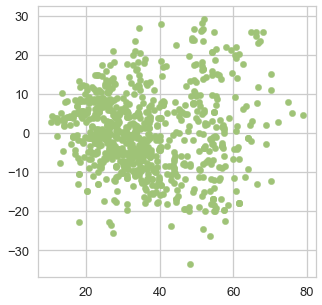

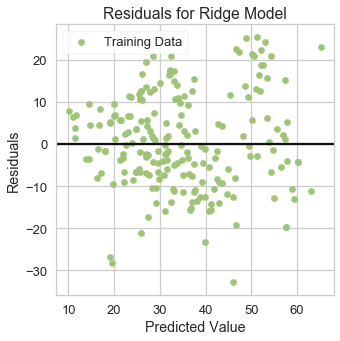

In [45]:
# Instantiate the linear model and visualizer 

#fig, ax = plt.subplots(figsize=(8,6)); 

ridge = Ridge()
visualizer = ResidualsPlot(ridge)
#visualizer = ResidualsPlot(ridge, ax=ax)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data 

# add histogram of residual errors
#left, bottom, width, height = [0.65, 0.17, 0.2, 0.2]
#ax2 = fig.add_axes([left, bottom, width, height])

#testing_residuals = pd.Series(visualizer.predict(X_test) - y_test)
#testing_residuals.plot(kind="hist", bins=50, title="Residuals on Predicted", ax=ax2);
#ax2.vlines(0, ymin=0, ymax=ax2.get_ylim()[1] ) # add x==0 line

g = visualizer.poof()             # Draw/show/poof the data
